# Using FairMedFM for SegFMs

This notebook further explores the internal modules of FairMedFM using segmentation. We have four modules, model, usage wrapper, dataloader, trainer, evaluation.

# Install FairMedFM

In [ ]:
!git clone https://github.com/FairMedFM/FairMedFM

%cd FairMedFM

In [ ]:
%mkdir data
%cd data
!wget https://object-arbutus.cloud.computecanada.ca/rjin/FairMedFM/TUSC.zip
!unzip TUSC.zip
%cd ..

In [ ]:
!wget https://object-arbutus.cloud.computecanada.ca:443/rjin/FairMedFM/pretrained.zip
!unzip pretrained.zip
!rm -f pretrained.zip

In [ ]:
!pip install icecream==2.1.3
!pip install SimpleITK==2.3.1
!pip install einops==0.8.0
!pip install ipdb==0.13.13
!pip install git+https://github.com/facebookresearch/segment-anything.git@6fdee8f2727f4506cfbbe553e23b895e2795658
!pip install timm==1.0.3
!pip install open-clip-torch==2.24.0
!pip install salesforce-lavis==1.0.2
!pip install git+https://github.com/openai/CLIP.git@a1d071733d7111c9c014f024669f959182114e33
!pip install MedCLIP==0.0.3
!pip install torchmetrics==1.4.0.post0
!pip install peft==0.11.1
!pip install git+https://github.com/transcendentsky/tutils.git@8b02b20c9caa5553c96a6413b739ac47385fd730
!pip install transformers==4.40.2

In [ ]:
!pip freeze

# Segmentation Example

In [10]:
# setting experiment parameters
import os
os.chdir("../")
import json
from utils import basics
import torch

class Settings(object):
    def __init__(self) -> None:
        self.task = "seg"
        self.usage = "seg2d" # choose to use 2d or 3d model
        self.dataset = "TUSC"
        self.sensitive_name = "Sex"
        self.pos_class = 255 # the value of the gt mask
        self.model = "SAM" # choose from "SAM", "MedSAM", "SAMMed2D", "FT-SAM", "TinySAM", "MobileSAM"
        self.sam_ckpt_path = "./pretrained/SAM.pth"
        self.img_size = 1024
        self.prompt = "center" # type of prompt, choose from "bbox", "rand", "rands", "center"
        self.save_folder = "./test/"
        
        self.cuda = True
        self.device = torch.device("cuda" if self.cuda else "cpu")
        self.data_setting = self.get_data_settings()  
              
        # the following attrs are used as a placeholder, not used for segmentation
        self.batch_size = 1
        self.method = "erm"
        self.augment = False
        self.random_seed = 0
        self.cls_balance = False
        self.total_epochs = 1

    def get_data_settings(self):
        with open(f"configs/datasets/{self.dataset}.json", "r") as f:
            data_setting = json.load(f)
            data_setting["augment"] = False
            data_setting["test_meta_path"] = data_setting[
                f"test_{str.lower(self.sensitive_name)}_meta_path"]

            if self.pos_class is not None:
                data_setting["pos_class"] = self.pos_class    
        return data_setting

settings = Settings()
logger = basics.setup_logger(
    "train", settings.save_folder, "history.log", screen=False, tofile=True)


## Get evaluate dataset (TUSC as an example)

In [5]:
from datasets.utils import get_dataset
test_data, test_dataloader, test_meta = get_dataset(settings, split="test")

print("The number of test samples: ", len(test_data))
print(test_meta.head())

loaded dataset  TUSC
The number of test samples:  860
   index          imagePath          labelPath     sex  age sexBinary
0      0   image/118_36.png   label/118_36.png  Female   44         F
1      1  image/184_239.png  label/184_239.png  Female   48         F
2      2    image/55_15.png    label/55_15.png  Female   40         F
3      3    image/23_63.png    label/23_63.png  Female   62         F
4      4    image/46_56.png    label/46_56.png  Female   38         F


## Get Model (SAM with bbox prompt as an example)

In [12]:
from models.utils import get_model
from wrappers.utils import get_warpped_model
from trainers.utils import get_trainer
import os
import torch
model = get_model(settings).to(settings.device)
model = get_warpped_model(settings, model, test_data).to(settings.device)  # SAMLearner
print("2D SegFM using 1 bounding box prompt performance:")
trainer = get_trainer(settings, model, logger, test_dataloader)


Weights of model: #SAM# is loaded!
2D SegFM using 1 bounding box prompt performance:


## Evaluate the test set

In [13]:
trainer.evaluate(test_dataloader, save_path=os.path.join(
    settings.save_folder, settings.prompt))

  0%|          | 0/860 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 

## Present Results

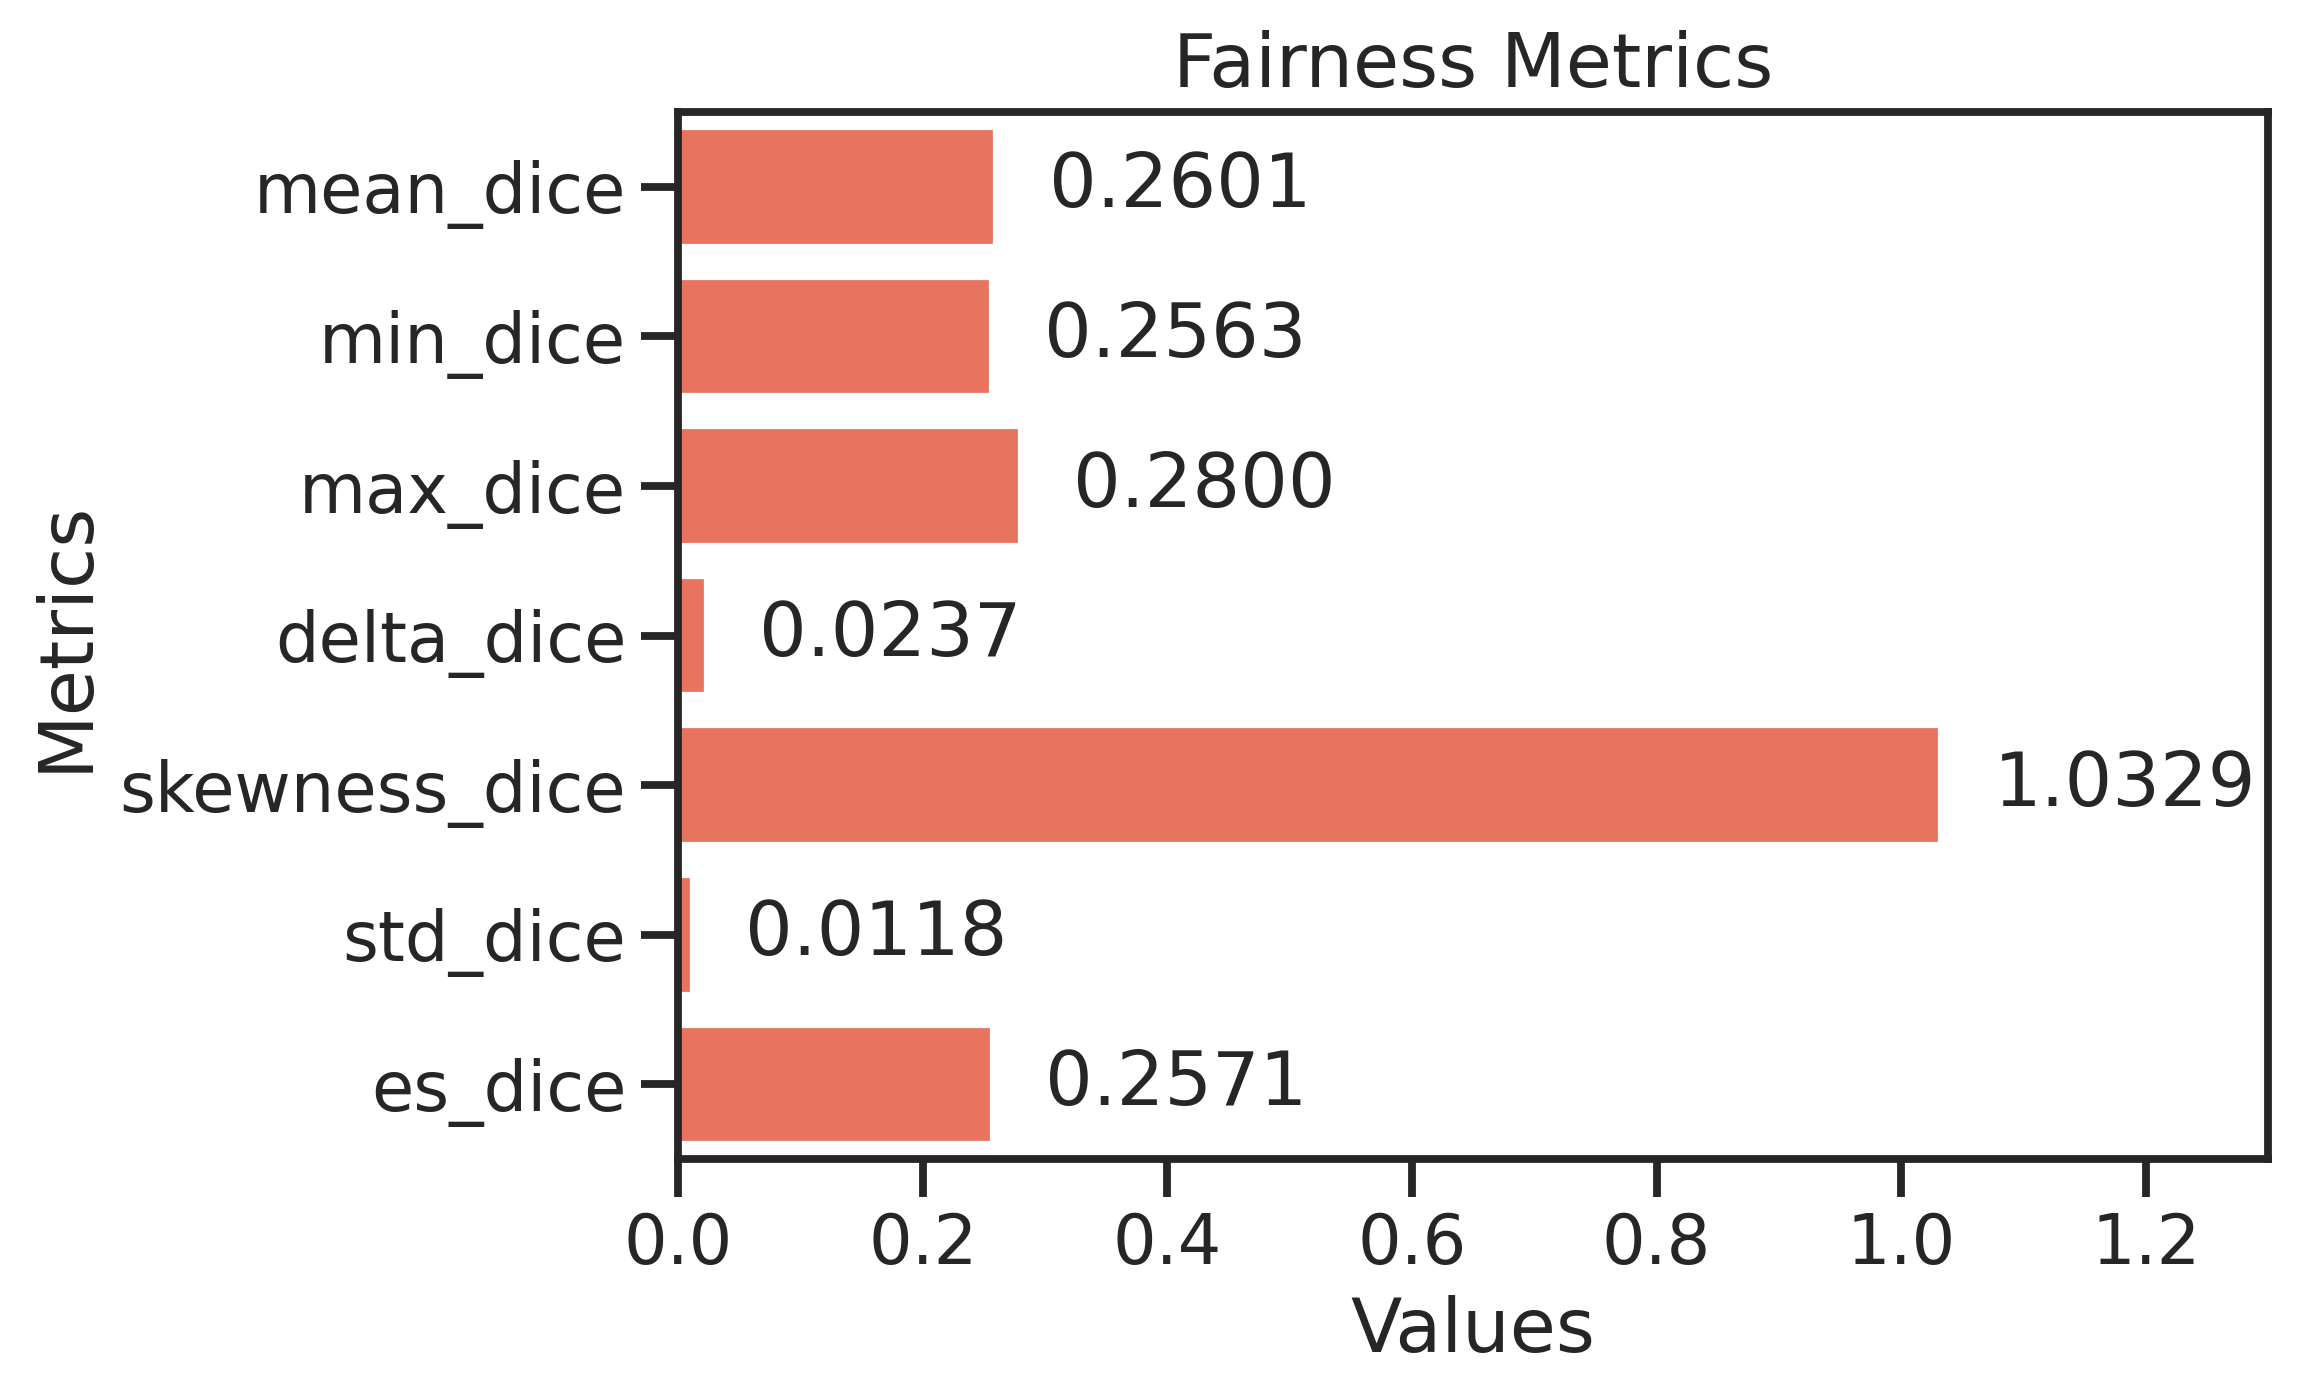

In [114]:
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
sns.set_theme(
    context="talk",
    style="ticks",
)

with open("./test/center/metrics.pkl", "rb") as f:
    metrics = pickle.load(f)

metrics["metrics"]

categories = list(metrics["metrics"].keys())
values = list(metrics["metrics"].values())

plt.figure(figsize=(8, 5), dpi=300)
ax = sns.barplot(x=values, y=categories, orient='h',color='#FF6347')

for i in ax.patches:
    ax.text(i.get_width() + 0.15, 
            i.get_y() + i.get_height() / 2, 
            f'{i.get_width():.4f}',
            ha='center', va='center')

# 添加标题和标签
plt.title('Fairness Metrics')
plt.xlabel('Values')
plt.xlim(0, 1.3)
plt.ylabel('Metrics')
plt.tight_layout()
plt.show()